In [26]:
%load_ext autoreload
%autoreload 2

import json
import re
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import Adam
from sklearn.model_selection import GroupKFold
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from time import time, sleep

from utils import *
from jigsaws_utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

seed = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print('Device:',torch.cuda.get_device_name(device))

def evaluate_model(model, gram_matrix, y, nsplits=5, d_transform=None):
    nsample = len(y)
    nsample_per_group = int(nsample/nsplits)
    repeats = [nsample_per_group]*(nsplits-1)
    repeats = repeats + [nsample-np.sum(repeats)]
    groups = np.repeat(np.arange(nsplits), repeats)
    kfolder = GroupKFold(n_splits=nsplits)

    confusion_matrix_cum = np.zeros((ngestures, ngestures))
    accuracy_cum = 0
    for train_index, test_index in kfolder.split(X, y, groups):
        if d_transform is not None:
            gram_train = d_transform(gram_matrix[train_index, :][:, train_index])
            gram_test = d_transform(gram_matrix[test_index, :][:, train_index])
        else:
            gram_train = gram_matrix[train_index, :][:, train_index]
            gram_test = gram_matrix[test_index, :][:, train_index]

        # Predict
        model.fit(gram_train, y[train_index])
        preds = model.predict(gram_test)
        cm = confusion_matrix(y[test_index], preds, normalize='true')

        # Handle of missing gestures
        if cm.shape != (ngestures,ngestures):
            missing_gestures = set(gestures) - set(preds) - set(y[test_index])
            l = cm.shape[0]
            for g in missing_gestures:
                gi = g2i[g]
                cm = np.insert(cm, gi, np.zeros(l), axis=1)
                cm = np.insert(cm, gi, np.zeros(l+1), axis=0)
                cm[gi,gi] = 1
                l = l+1

        confusion_matrix_cum += cm/nsplits
    accuracy = np.mean(np.diag(confusion_matrix_cum))

    return accuracy, confusion_matrix_cum

def plot_distr(classes, counts, task, alpha=1):
    nclass = len(classes)
    x = range(nclass)
    plt.figure(figsize=(12, 8))
    plt.title('Distribution of gestures for task '+i2task[task])
    plt.bar(x, counts, alpha=alpha, width=0.5)
    plt.xticks(x, classes)
    plt.xlabel('Gesture id')
    plt.ylabel('Number of instances of gesture')
    plt.savefig('data_generated/gesture_distribution_'+i2task[task]+'.png')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Device: Tesla P100-PCIE-12GB


Missing file for: task 'Knot_Tying', subject 'B', trial 5
Missing file for: task 'Knot_Tying', subject 'H', trial 1
Missing file for: task 'Knot_Tying', subject 'I', trial 4


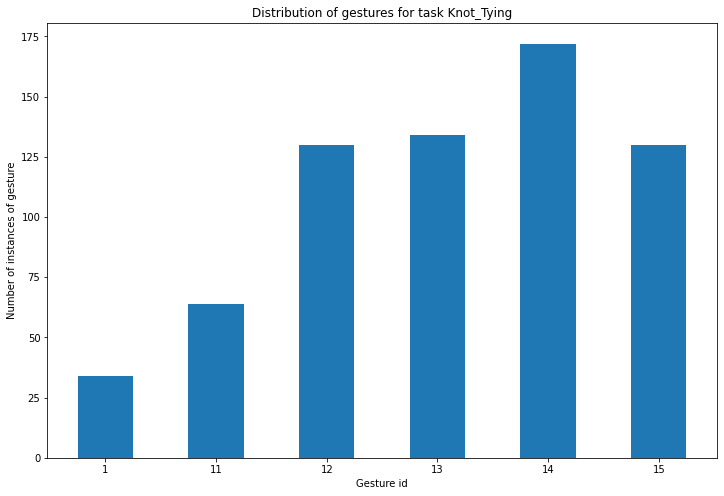

Missing file for: task 'Needle_Passing', subject 'B', trial 5
Missing file for: task 'Needle_Passing', subject 'E', trial 2
Missing file for: task 'Needle_Passing', subject 'F', trial 2
Missing file for: task 'Needle_Passing', subject 'H', trial 1
Missing file for: task 'Needle_Passing', subject 'I', trial 1


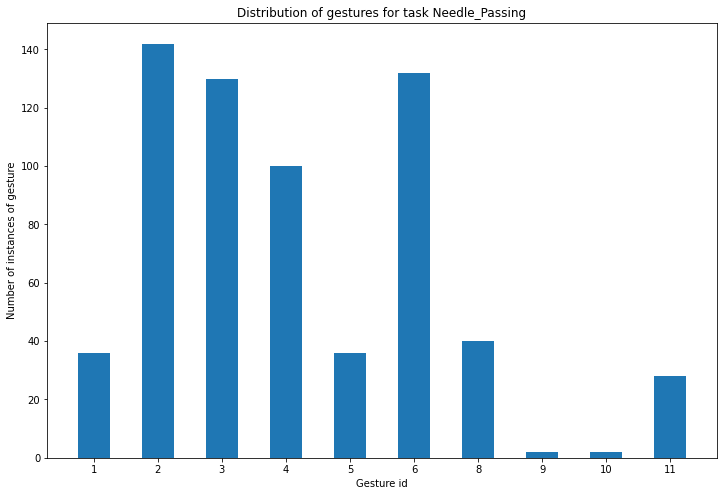

Missing file for: task 'Suturing', subject 'H', trial 2


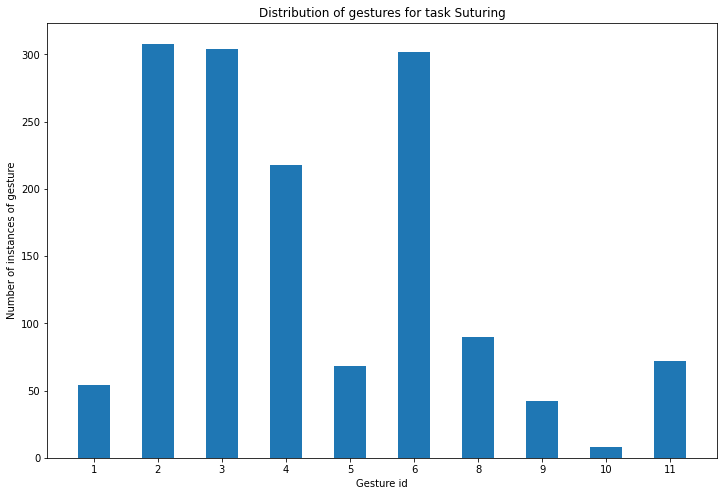

In [27]:
for task in range(3):
    _, y = load_video_data(tasks=task)
    plot_distr(*np.unique(y, return_counts=True), task)
    plt.show()

In [12]:
gestures_for_tasks = [[1,11,12,13,14,15],
                      [1,2,3,4,5,6,7,8,11],
                      [1,2,3,4,5,6,8,9,11]]

## Evaluation for all tasks and subjects

Setup 1: for every task, subject and number of neighbors compute the test accuracy on one fifth of the subject's trials with 5-fold cross-validation. This gives an average accuracy over the fold of each subject. Then average accuracy between the subjects (within the tasks) and plot the average (biased) test accuracy with respect to K.

Setup 2: for every task, do as setup 1 except leave one subject out. After applying same procedure as setup 1, pick the best hyperparameter and classify the last subject, which would be the test accuracy.

Setup 2 split according to train-validation-test instead of train-test (using test to validate the hyperparameters). But I think setup 1 makes more sense as we are in a experimental framework, not in an evaluation framework.

Note: For now, I don't do this, I aggregate all points of a user and run sklearn's corss-validation on it, trials will not be taken into account for the splitting.

In [ ]:
ks = np.arange(1, 8)
gammas = np.logspace(-10, -3, base=2, num=10)
ncomp = 10

all_confusions_baseline_knn = []
all_confusions_baseline_svm = []
all_accuracies_baseline_knn  = []
all_accuracies_baseline_svm  = []
all_measures = [all_confusions_baseline_knn, all_confusions_baseline_svm,
               all_accuracies_baseline_knn, all_accuracies_baseline_svm]
start = time()
for task in range(ntask):
    all_confusions_baseline_knn.append([])
    all_confusions_baseline_svm.append([])
    all_accuracies_baseline_knn.append([])
    all_accuracies_baseline_svm.append([])
    print(i2task[task]+':')
    task_dir = 'data/JIGSAWS_converted/'+i2task[task]
    stream = os.popen("find %s -name '*.avi' | sed 's:^.*_\([A-Z][0-9]\{3\}\)_[^_]\+$:\\1:'" % task_dir)
    video_meta = list(filter(lambda x: x != '', stream.read().split('\n')))
    task_subjects = np.unique([x[0] for x in video_meta])
    for subject in task_subjects:
        # Load data and fit the systems
        video_data, y = load_video_data(tasks=task, subjects=subject, gestures=gestures_for_tasks[task])
        nsample = len(y)
        gestures = np.unique(y)
        ngestures = len(gestures)
        g2i = {g: i for i, g in enumerate(gestures)}
        X = []
        mask_videos = np.full(y.shape, True)
        for vi, video in enumerate(video_data):
            if video.duration_frames < ncomp:
                # Filter too short fragments, frames in annotations do not correspond to videos
                mask_videos[vi] = False
                continue
            video.torch = False
            all_frames = video.get_all_frames()

            compression_model = custom_pca(ncomp)
            compression_model.fit(all_frames)
            frames_enc, shape = compression_model.encode(all_frames)
            A = np.linalg.pinv(frames_enc[:-1])@frames_enc[1:]

            X.append((compression_model, A))
        print(f'{task} {subject} {nsample}', y.shape, sum(mask_videos))
        y = y[mask_videos]
        print(y.shape)

        # Compute all distances
        full_martin_gram = np.zeros((len(X), len(X)))
        for i, mi in enumerate(X):
            for j, mj in enumerate(X):
                if i > j:
                    full_martin_gram[i,j] = full_martin_gram[j,i]
                else:
                    # Check: negative values appear when computing distance. For the moment round them to zero
                    # while verifying they are all small enough
                    martin_dist_curr = martin_dist(mi, mj)
                    if martin_dist_curr < -1e-13:
                        raise ValueError('Negative values should not appear.')

                    full_martin_gram[i,j] = martin_dist_curr
        full_martin_gram[full_martin_gram < 0] = 0

        # Evaluation using KNN
        confusions_baseline_knn = np.zeros((len(ks), ngestures, ngestures))
        accuracies_baseline_knn = np.zeros(len(ks))
        for ki, k in enumerate(ks):
            knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed', n_jobs=-1)
            accuracy, conf_matrix = evaluate_model(knn, full_martin_gram, y)
            accuracies_baseline_knn[ki] = accuracy
            confusions_baseline_knn[ki] = conf_matrix
        all_confusions_baseline_knn[task].append(confusions_baseline_knn)
        all_accuracies_baseline_knn[task].append(accuracies_baseline_knn)

        # Evaluation using SVM
        svm_model = SVC()
        confusions_baseline_svm = np.zeros((len(gammas), ngestures, ngestures))
        accuracies_baseline_svm = np.zeros(len(gammas))
        for gammai, gamma in enumerate(gammas):
            accuracy, conf_matrix = evaluate_model(svm_model, full_martin_gram, y, d_transform=lambda x: np.exp(-gamma*x))
            accuracies_baseline_svm[gammai] = accuracy
            confusions_baseline_svm[gammai] = conf_matrix
        all_confusions_baseline_svm[task].append(confusions_baseline_svm)
        all_accuracies_baseline_svm[task].append(accuracies_baseline_svm)

        print('\tSubject '+subject+': '+sec2string(time()-start))

In [ ]:
# Extract best models for (baseline,) x (SVM, KNN) x (Martin, Frobenius)
task_curves = []
task_labels = []
for i, (baseline_confs_knn, baseline_confs_svm, baseline_acc_knn, baseline_acc_svm) in enumerate(zip(*all_measures)):
    task_curves.append([])
    task_labels.append([])

    task_curves[i].append([])
    for accs in baseline_acc_knn:
        task_curves[i][0].append